# Selecting the Fantasy MVPs

### MSP 9.24.2017

Who are the 2017 hitting and pitching MVPs?

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import matplotlib as mpl



In [4]:
# imports for scraping

from bs4 import BeautifulSoup
import requests


# basic birth year reader. tables[1] has good stuff in it!
def get_birth_year(tables):

    birthdate_start = (tables[1].text).find("Birthdate:")

    birthdate_end =  (tables[1].text).find('(',birthdate_start)

    #print (tables[1].text)[birthdate_start:birthdate_end]
    birth_year = (tables[1].text)[birthdate_start:birthdate_end].split('/')[2]
    #print birth_year
    
    return birth_year





In [5]:
# the listing of the teams of interest (all!)

teams = ['angels','astros','athletics','bluejays','braves',\
        'brewers','cardinals','cubs','diamondbacks','dodgers',\
        'giants','indians','mariners','marlins','mets','nationals',\
        'orioles','padres','phillies','pirates','rangers',\
        'rays','reds','redsox','rockies','royals','tigers','twins',\
        'whitesox','yankees']

# verify we got all the teams...
print len(teams)

30


#### Compile Hitters

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [6]:
#
# make hitter dictionary
#
HDict = {}


for team in teams:
    
    print team,
    
    get_url = 'http://www.fangraphs.com/teams/'+team#angels'

    r  = requests.get(get_url)

    data = r.text

    soup = BeautifulSoup(data)

    tables = soup.findAll('table')


    for row in tables[5].find_all("tr")[1:]: 
    
        sav = [td.find('a') for td in row.find_all("td")][0]
    
        try:
            need_url = sav.get('href')
            
            sav2 = [td.get_text() for td in row.find_all("td")]
        
            # Apply a PA cut?
            if float(sav2[3]) > 200.:
                HDict[sav.text] = need_url[(need_url).find('playerid')+9:(need_url).find('&')]
        
        except:
            pass
    
f = open('data/batterdict.dat','w')

for entry in HDict.keys():
    try:
        print >>f,entry,'|',HDict[entry]
    except:
        print entry,'|',HDict[entry]
    

f.close()

angels astros athletics bluejays braves brewers cardinals cubs diamondbacks dodgers giants indians mariners marlins mets nationals orioles padres phillies pirates rangers rays reds redsox rockies royals tigers twins whitesox yankees KikÃ© Hernandez | 10472


In [7]:

HDict = {}

f = open('data/batterdict.dat')

for line in f:
    #print line
    try:
        HDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    
    
print('Found {} hitters by scraping teams.'.format(len(HDict.keys())))

Found 331 hitters by scraping teams.


### First Application: Grabbing A Hitters AVG/OBP with age

How does a plot of avg/obp evolve with age?

In [8]:
#
# for an individual player
#'

itable = [u'Season', u'Team', u'G', u'AB', u'PA', u'H', u'1B', \
          u'2B', u'3B', u'HR', u'R', u'RBI', u'BB', u'IBB',\
          u'SO', u'HBP', u'SF', u'SH', u'GDP', u'SB', u'CS', u'AVG']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17      18       19      20     21


# these are categories to eliminate
projections = ['Depth Charts','Fans',\
               'Fans (6)','Fans (7)','Fans (11)','Fans (12)','Fans (14)','Fans (15)',\
               'Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average','Postseason']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total','Postseason']



plist = ['Joey Votto','Albert Pujols','Mike Trout']


#for player in HDict.keys():

def obtain_players(plist):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        PVals[player] = {}
        #print player,

        get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(HDict[player].strip())

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')

        PVals[player]['1B'] = []
        PVals[player]['2B'] = []
        PVals[player]['3B'] = []
        PVals[player]['HR'] = []
        PVals[player]['R']  = []
        PVals[player]['RBI'] = []
        PVals[player]['AB'] = []
        PVals[player]['SB'] = []
        PVals[player]['SO'] = []


        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                print pnum,player

                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:

                    if (row in table.find_all("tr", class_="grid_postseason")) |\
                        (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue


                    sav = [td.get_text() for td in row.find_all("td")]

                    if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    (np.sum([(x in sav[1]) for x in minors])==0) & \
                    (np.sum([(x in sav[0]) for x in agg])==0) &\
                    (sav[0] == '2017'): 
                        try:
                            #print sav[0]
                            float(sav[-1])
                            float(sav[0])

                            #print sav[0],sav[1],float(sav[4])>50.

                            # current problem is that postseason is mixed in

                            if (float(sav[4])>50.):
                                # sav[4] is PA
                                PVals[player]['1B'].append(float(sav[6]))
                                PVals[player]['2B'].append(float(sav[7]))
                                PVals[player]['3B'].append(float(sav[8]))
                                PVals[player]['HR'].append(float(sav[9]))
                                PVals[player]['R'].append(float(sav[10]))
                                PVals[player]['RBI'].append(float(sav[11]))
                                PVals[player]['AB'].append(float(sav[3]))
                                PVals[player]['SB'].append(float(sav[19]))
                                PVals[player]['SO'].append(float(sav[14]))

                            #if (float(sav[7])<50.):
                            #    print 'rejected for too few innings:',sav[0],float(sav[7])

                        except:
                            # this is janky way to skip postseason. please fix this
                            #print 'Skipped for postseason',sav[0],sav[1]
                            pass

    return PVals


PValsFull = obtain_players(HDict.keys())



0 Rougned Odor
1 Justin Upton
2 Brad Miller
3 Kevan Smith
4 Ryan Braun
5 Jose Bautista
6 Carlos Asuaje
7 Bruce Maxwell
8 Matt Olson
9 Stephen Piscotty
10 Wilson Ramos
11 Cameron Maybin
12 Hernan Perez
13 Adam Duvall
14 Adrian Gonzalez
15 Matt Joyce
16 Daniel Robertson
17 Dustin Pedroia
18 Gary Sanchez
19 J.T. Realmuto
20 Nori Aoki
21 Joey Gallo
22 Evan Gattis
23 Gregor Blanco
24 Ian Kinsler
25 Chris Owings
26 Christian Vazquez
27 Kevin Pillar
28 J.T. Riddle
29 Mike Zunino
30 Greg Garcia
31 Caleb Joseph
32 Denard Span
33 Adam Engel
34 Jose Ramirez
35 John Jaso
36 Corey Dickerson
37 Travis d'Arnaud
38 Tommy Pham
39 Kolten Wong
40 Mitch Haniger
41 Albert Pujols
42 Billy Hamilton
43 Orlando Arcia
44 Russell Martin
45 Yoan Moncada
46 Travis Shaw
47 Neil Walker
48 Joe Panik
49 Freddy Galvis
50 Gorkys Hernandez
51 Jason Castro
52 Alex Presley
53 Welington Castillo
54 Francisco Lindor
55 Ben Zobrist
56 Jackie Bradley Jr.
57 George Springer
58 Starling Marte
59 Jake Lamb
60 Brandon Moss
61 Edua

In [70]:


def plot_plist(plist,PVals):

    fig = plt.figure(figsize=(5,6))
    
    # 1 | 2
    # 1 | 4
    #

    ax1 = fig.add_axes([0.15,0.15,0.7,0.15])
    ax2 = fig.add_axes([0.15,0.30,0.7,0.15])
    ax3 = fig.add_axes([0.15,0.45,0.7,0.15])
    ax4 = fig.add_axes([0.15,0.60,0.7,0.15])
    ax5 = fig.add_axes([0.15,0.75,0.7,0.15])
    ax6 = fig.add_axes([0.9,0.15,0.02,0.7])

    clrs = cm.gnuplot
    
    #ax1.hexbin(twob,fourb,cmap=cm.Greys,gridsize=10)


    for indx,player in enumerate(plist):
        ax1.plot(np.cumsum(PVals[player]['h'])/np.cumsum(PVals[player]['ab']),color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax2.plot(np.cumsum(PVals[player]['sb']),color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax3.plot(np.cumsum(PVals[player]['hr']),color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax4.plot(np.cumsum(PVals[player]['rbi']),color=cm.gnuplot(indx/float(len(plist)-1.),1.))
        ax5.plot(np.cumsum(PVals[player]['r']),color=cm.gnuplot(indx/float(len(plist)-1.),1.))




    ax1.set_ylabel('AVG',size=18)
    ax2.set_ylabel('SB',size=18)
    ax3.set_ylabel('HR',size=18)
    ax4.set_ylabel('RBI',size=18)
    ax5.set_ylabel('R',size=18)

    ax1.set_xlabel('Game',size=18)



    ax2.set_xticklabels(())
    ax3.set_xticklabels(())
    ax4.set_xticklabels(())
    ax5.set_xticklabels(())


    norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(plist)+1.), ncolors=256)
    cb1 = mpl.colorbar.ColorbarBase(ax6, cmap=cm.gnuplot,norm=norm)
    cb1.set_label('Players',size=16)
    cb1.set_ticks(np.linspace(0.,1.,len(plist)+1.) + 0.5/(len(plist)+1.))
    cb1.set_ticklabels(plist)



### Find the Outliers

Player-Rater style.

In [11]:

thits = np.array([PValsFull[x]['1B'] for x in PValsFull.keys()]) +\
        np.array([PValsFull[x]['2B'] for x in PValsFull.keys()]) +\
        np.array([PValsFull[x]['3B'] for x in PValsFull.keys()]) +\
        np.array([PValsFull[x]['HR'] for x in PValsFull.keys()])


AVG = {}
AVG['RBI'] = np.mean(np.array([PValsFull[x]['RBI'] for x in PValsFull.keys()]))
AVG['R'] = np.mean(np.array([PValsFull[x]['R'] for x in PValsFull.keys()]))
AVG['SB'] = np.mean(np.array([PValsFull[x]['SB'] for x in PValsFull.keys()]))
AVG['HR'] = np.mean(np.array([PValsFull[x]['HR'] for x in PValsFull.keys()]))
AVG['AVG'] = np.mean(thits/np.array([PValsFull[x]['AB'] for x in PValsFull.keys()]))

MED = {}
MED['RBI'] = np.median(np.array([PValsFull[x]['RBI'] for x in PValsFull.keys()]))
MED['R'] = np.median(np.array([PValsFull[x]['R'] for x in PValsFull.keys()]))
MED['SB'] = np.median(np.array([PValsFull[x]['SB'] for x in PValsFull.keys()]))
MED['HR'] = np.median(np.array([PValsFull[x]['HR'] for x in PValsFull.keys()]))
MED['AVG'] = np.median(thits/np.array([PValsFull[x]['AB'] for x in PValsFull.keys()]))


STD = {}
STD['RBI'] = np.std(np.array([PValsFull[x]['RBI'] for x in PValsFull.keys()]))
STD['R'] = np.std(np.array([PValsFull[x]['R'] for x in PValsFull.keys()]))
STD['SB'] = np.std(np.array([PValsFull[x]['SB'] for x in PValsFull.keys()]))
STD['HR'] = np.std(np.array([PValsFull[x]['HR'] for x in PValsFull.keys()]))
STD['AVG'] = np.std(thits/np.array([PValsFull[x]['AB'] for x in PValsFull.keys()]))








In [13]:
for key in AVG.keys():
    print('{0:4s}{1:8.3f}{2:8.3f}{3:8.3f}'.format(key,AVG[key],MED[key],STD[key]))

HR    15.943  14.000   9.893
SB     6.517   4.000   8.205
R     57.033  54.000  22.659
RBI   54.761  53.000  24.437
AVG    0.262   0.263   0.030


In [75]:
Outlay = {}
Outlay['HR'] = {}
Outlay['R'] = {}
Outlay['RBI'] = {}
Outlay['AVG'] = {}
Outlay['SB'] = {}

Outlay['Total'] = {}
Outlay['TotalHSB'] = {}
Outlay['TotalHAV'] = {}


gdict = MED


for indx,player in enumerate(PValsFull.keys()):

    Outlay['HR'][player] = (PValsFull[player]['HR'] - gdict['HR'])/STD['HR']
    Outlay['R'][player] = (PValsFull[player]['R'] - gdict['R'])/STD['R']
    Outlay['RBI'][player] = (PValsFull[player]['RBI'] - gdict['RBI'])/STD['RBI']
    Outlay['SB'][player] = (PValsFull[player]['SB'] - gdict['SB'])/STD['SB']
    Outlay['AVG'][player] = (((thits[indx]/PValsFull[player]['AB']) - gdict['AVG'])/STD['AVG'])
    Outlay['Total'][player] = np.sum([Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player], \
                              Outlay['SB'][player],Outlay['AVG'][player]])
    Outlay['TotalHSB'][player] = np.sum([Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player], \
                              0.5*Outlay['SB'][player],Outlay['AVG'][player]])
    Outlay['TotalHAV'][player] = np.sum([Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player], \
                              Outlay['SB'][player],0.5*Outlay['AVG'][player]])



In [76]:
for player in Outlay['SB'].keys()[0:10]:
    
    print player,Outlay['SB'][player],0.5*Outlay['SB'][player]

Rougned Odor [ 1.21879452] [ 0.60939726]
Justin Upton [ 0.85315617] [ 0.42657808]
Yunel Escobar [-0.36563836] [-0.18281918]
Brad Miller [ 0.] [ 0.]
Aaron Altherr [ 0.12187945] [ 0.06093973]
Kevan Smith [-0.48751781] [-0.2437589]
Ryan Braun [ 0.97503562] [ 0.48751781]
Jose Bautista [ 0.2437589] [ 0.12187945]
Carlos Asuaje [-0.48751781] [-0.2437589]
Bruce Maxwell [-0.48751781] [-0.2437589]


In [77]:
print Outlay['Total']['Mike Trout']

6.97660812175


In [86]:
print('{0:^20s}{1:^7s}{2:^7s}{3:^7s}'.format('Player','Total','0.5SB','0.5AVG'))
print('-----------------------------------------')



for player in Outlay['Total'].keys():
    
    if Outlay['Total'][player] > 8.:
        
        print('{0:20s}{1:7.2f}{2:7.2f}{3:7.2f}'.format(player,Outlay['Total'][player],Outlay['TotalHSB'][player],Outlay['TotalHAV'][player]))
        #print Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player],Outlay['SB'][player],Outlay['AVG'][player]
        #print np.sum([Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player],Outlay['SB'][player],Outlay['AVG'][player]])

        #print np.sum([Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player],0.5*Outlay['SB'][player],Outlay['AVG'][player]])
        #print np.sum([Outlay['HR'][player],Outlay['R'][player],Outlay['RBI'][player],Outlay['SB'][player],0.5*Outlay['AVG'][player]])

       Player        Total  0.5SB 0.5AVG 
-----------------------------------------
Paul Goldschmidt      10.78   9.92  10.05
Aaron Judge            9.18   8.94   8.91
Nolan Arenado          8.13   8.19   7.44
Charlie Blackmon      10.38   9.84   9.36
Jose Altuve           10.52   8.81   9.15
Dee Gordon             8.11   4.94   7.38
Giancarlo Stanton     10.42  10.54  10.15


In [87]:
#
# for the top candidates, make a curve.
#'

itable = [u'Date', u'Team', u'Opp', u'BO', u'Pos', u'PA', u'H',\
          u'2B', u'3B', u'HR', u'R', u'RBI', u'SB', u'CS',\
          u'BB%', u'K%', u'ISO', u'BABIP', u'AVG', u'OBP', u'SLG', u'wOBA', u'wRC+']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17          18       19      20     21      22




plist = ['Paul Goldschmidt','Charlie Blackmon','Jose Altuve','Giancarlo Stanton']


#for player in HDict.keys():

def obtain_players(plist):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        PVals[player] = {}
        #print player,

        get_url = 'http://www.fangraphs.com/statsd.aspx?playerid='+str(HDict[player].strip())
        
        #print get_url

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')

        birth_year = float(get_birth_year(tables))

        PVals[player]['bo'] = []
        PVals[player]['pos'] = []
        PVals[player]['h'] = []
        PVals[player]['ab'] = []
        PVals[player]['hr'] = []
        PVals[player]['rbi'] = []
        PVals[player]['r'] = []
        PVals[player]['sb'] = []



        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                if (pnum % 1) == 0:
                    print pnum,player

                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:
                    

                    if (row in table.find_all("tr", class_="grid_postseason")) |\
                        (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue


                    sav = [td.get_text() for td in row.find_all("td")]
                    
                    #print sav
                    
                    #print sav
                
                    
                    if ('Date' not in sav[0]) & ('Total' not in sav[0]) :
                        PVals[player]['bo'].append(float(sav[3]))
                        PVals[player]['h'].append(float(sav[6]))
                        PVals[player]['ab'].append(float(sav[5]))
                        PVals[player]['hr'].append(float(sav[9]))
                        PVals[player]['rbi'].append(float(sav[11]))
                        PVals[player]['r'].append(float(sav[10]))
                        PVals[player]['sb'].append(float(sav[12]))
                        
                        try:
                            if sav[4][1] == 'F': 
                                PVals[player]['pos'].append('OF')
                        
                            elif sav[4][1] == '-':
                                PVals[player]['pos'].append(sav[4][0:1])
                        
                            else:
                                PVals[player]['pos'].append(sav[4][0:2])
                                
                        except:
                            PVals[player]['pos'].append(sav[4][0:1])

                    #if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    #(np.sum([(x in sav[1]) for x in minors])==0) & \
                    #(np.sum([(x in sav[0]) for x in agg])==0): 
                    #    try:
                    #        PVals[player]['bo'].append(float(sav[0])-birth_year)
                    #        PVals[player]['pos'].append(float(sav[14])/float(sav[4]))
                    #        PVals[player]['bbr'].append(float(sav[12])/float(sav[4]))

                    #    except:
                    #        # this is janky way to skip postseason. please fix this
                    #        #print 'Skipped for postseason',sav[0],sav[1]
                    #        pass

    return PVals


PVals = obtain_players(plist)




0 Paul Goldschmidt
1 Charlie Blackmon
2 Jose Altuve
3 Giancarlo Stanton


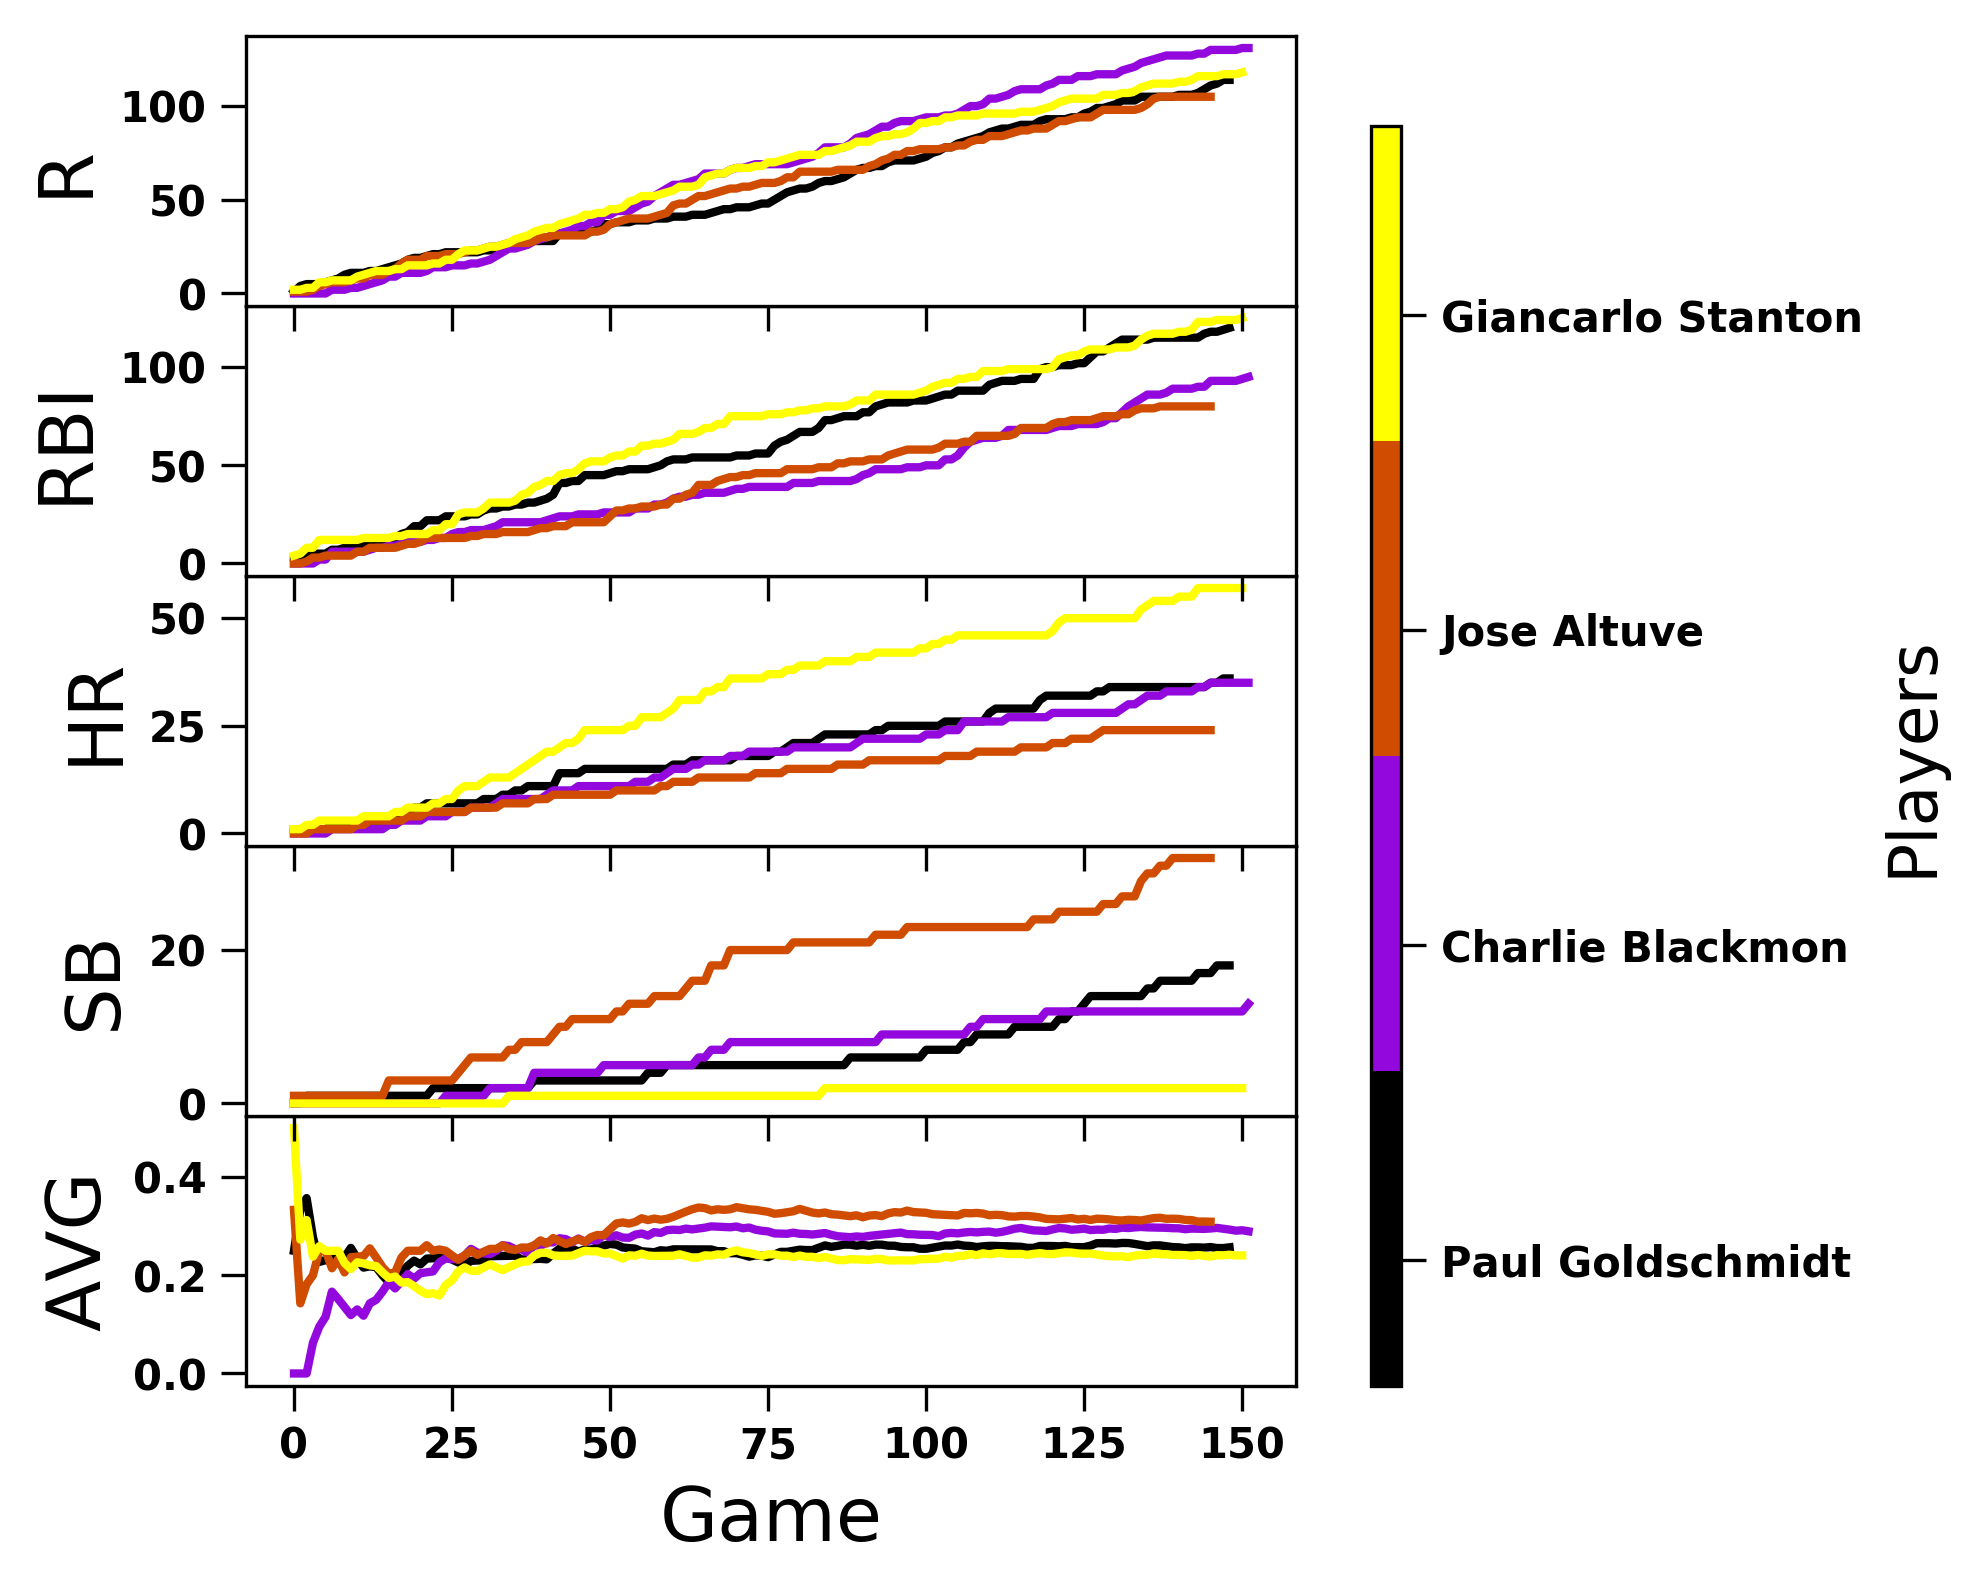

In [88]:
plot_plist(plist,PVals)

In [105]:
# draw 6 random games from the sample and see how RBIs go

nsamp = 10000

MCarlo = {}
MCarlo['HR'] = {}
MCarlo['R'] = {}
MCarlo['RBI'] = {}
MCarlo['SB'] = {}




for player in plist:
    
     
    
    start = np.random.randint(0,len(PVals[player]['hr'])-6,nsamp)
    
    MCarlo['HR'][player] = np.mean(np.array([np.sum(PVals[player]['hr'][startx:startx+6]) for startx in start]))
    MCarlo['R'][player] = np.mean(np.array([np.sum(PVals[player]['r'][startx:startx+6]) for startx in start]))
    MCarlo['RBI'][player] = np.mean(np.array([np.sum(PVals[player]['rbi'][startx:startx+6]) for startx in start]))
    MCarlo['SB'][player] = np.mean(np.array([np.sum(PVals[player]['sb'][startx:startx+6]) for startx in start]))



    




In [107]:
print MCarlo['HR']
print MCarlo['R']
print MCarlo['RBI']
print MCarlo['SB']

{'Paul Goldschmidt': 1.4340999999999999, 'Jose Altuve': 1.0247999999999999, 'Giancarlo Stanton': 2.2824, 'Charlie Blackmon': 1.4436}
{'Paul Goldschmidt': 4.4744000000000002, 'Jose Altuve': 4.4694000000000003, 'Giancarlo Stanton': 4.7039999999999997, 'Charlie Blackmon': 5.3311000000000002}
{'Paul Goldschmidt': 4.8079000000000001, 'Jose Altuve': 3.4119999999999999, 'Giancarlo Stanton': 4.8578000000000001, 'Charlie Blackmon': 3.8222}
{'Paul Goldschmidt': 0.70079999999999998, 'Jose Altuve': 1.3286, 'Giancarlo Stanton': 0.079600000000000004, 'Charlie Blackmon': 0.49469999999999997}
